Assignment 1: 

Name: 

UID:

Please submit to Gradescope
- a PDF containing all outputs (by executing **Run all**)
- your ipynb notebook containing all the code

I understand the policy on academic integraty (collaboration and the use of online material).
Please sign your name here: 


# Part A: Hybrid Image (25 Points)

## Overview

A hybrid image is the sum of a *low-pass filtered* version of the one image and a *high-pass filtered* version of a second image. There is a free parameter, which can be tuned for each image pair, which controls how much high frequency to remove from the first image and how much low frequency to leave in the second image. This is called the “cutoff-frequency”. In the paper it is suggested to use two cutoff frequencies (one tuned for each image) and you are free to try that, as well. In the starter code, the cutoff frequency is controlled by changing the standard deviation of the Gausian filter used in constructing the hybrid images. [This](https://drive.google.com/uc?id=187FjBJLwnYXhylx08Vdh1SAA3AO-imYv) is the sample example.

NOTE: 

1. Reading [this](https://stanford.edu/class/ee367/reading/OlivaTorralb_Hybrid_Siggraph06.pdf) will help in understanding Part A.

2. You can use any image processing libraries of your choice such as skimage or cv2; in python.

We provided 7 pairs of aligned images. The alignment is important because it affects the perceptual grouping (read the paper for details). We encourage you to create additional examples (e.g. change of expression, morph between different objects, change over time, etc.).

You are required to provide **THREE hybrid image results** and for ONE of your favorite result, please provide answers to the following **FOUR sub-parts** mentioned in the write-up.

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [5]:
# Download Data -- run this cell only one time per runtime
!gdown 1KTDxPAkQam29YKtoX5dKPnLKpUOWCanC
#!unzip "/content/hybrid_pyramid_input.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=1KTDxPAkQam29YKtoX5dKPnLKpUOWCanC
To: C:\Users\micro\Downloads\New python 22.9.22\hybrid_pyramid_input.zip

  0%|          | 0.00/2.19M [00:00<?, ?B/s]
 24%|##3       | 524k/2.19M [00:04<00:13, 127kB/s]
 48%|####7     | 1.05M/2.19M [00:07<00:08, 138kB/s]
 72%|#######1  | 1.57M/2.19M [00:10<00:04, 153kB/s]
 96%|#########5| 2.10M/2.19M [00:14<00:00, 152kB/s]
100%|##########| 2.19M/2.19M [00:14<00:00, 157kB/s]
100%|##########| 2.19M/2.19M [00:14<00:00, 151kB/s]
unzip:  cannot find either /content/hybrid_pyramid_input.zip or /content/hybrid_pyramid_input.zip.zip.


## Code

In [113]:
# Helper Functions
# Helper Functions
def vis_hybrid_image(hybrid_image):
  scales = 5
  scale_factor = 0.5
  padding = 5
  original_height = hybrid_image.shape[0]
  num_colors = hybrid_image.shape[2] # counting how many color channels the input has
  output = hybrid_image
  cur_image = hybrid_image

  for i in range(2, scales):
      # add padding
      output = np.concatenate((output, np.ones((original_height, padding, num_colors), dtype=int)), axis=1)      
      # dowsample image;
      width = int(cur_image.shape[1] * scale_factor)
      height = int(cur_image.shape[0] * scale_factor)
      dim = (width, height)
      cur_image = cv2.resize(cur_image, dim, interpolation = cv2.INTER_LINEAR)
      # pad the top and append to the output
      tmp = np.concatenate((np.ones((original_height-cur_image.shape[0], cur_image.shape[1], num_colors)), cur_image), axis=0)
      output = np.concatenate((output, tmp), axis=1)
  
  output = (output * 255).astype(np.uint8)
  return output

def read_image(image_path):
  image=cv2.imread(image_path,cv2.IMREAD_COLOR)
  return image

def gaussian_2D_filter(size, cutoff_frequency):
  index_max=(size-1)/2
  arr1=np.linspace(-index_max,index_max,size)
  x_axis_range,y_axis_range=np.meshgrid(arr1,arr1)

  normalization=1/(2*np.pi*cutoff_frequency**2)
  filter= (normalization)*np.exp(-0.5*(np.square(x_axis_range)+np.square(y_axis_range))/np.square(cutoff_frequency))
  return filter/np.sum(filter)


def imgfilter(image, filter):
  filtered_image=cv2.filter2D(image,-1,filter)
  return filtered_image

def log_mag_FFT(image):

  image_toprocess=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  output=np.log(np.abs(np.fft.fftshift(np.fft.fft2(image_toprocess))))

  return output

def log_mag_FFT1(image):

  output=np.log(np.abs(np.fft.fftshift(np.fft.fft2(image))))

  return output

In [151]:
def compute_hybridimage(path1,path2,cutoff_frequency_):
    image_path1 = path1
    image_path2 = path2

    image_1 = read_image(image_path1)
    image_2 = read_image(image_path2)


    # YOUR CODE HERE: TUNE cutoff_frequency
    cutoff_frequency = cutoff_frequency_
    filter_size = int(cutoff_frequency*4+1)

    """cutoff_frequency is the standard deviation, in pixels, of the 
    Gaussian blur that will remove the high frequencies from one image (image_1) and 
    remove the low frequencies from another image (image_2) (to do so, subtract a blurred
    version from the original version). You will want to tune this for every image pair to get the best results."""

    filter = gaussian_2D_filter(filter_size, cutoff_frequency)
  

    """Use imgfilter() to create 'low_frequencies' and 'high_frequencies' and then combine them to create 'hybrid_image'.
    Remove the high frequencies from image_1 by blurring it. The amount of blur that works best will vary with different image pairs."""

    blurred_image1 = imgfilter(image_1, filter)
    low_frequencies = blurred_image1
 

    """Remove the low frequencies from image_2. The easiest way to do this is to
    subtract a blurred version of image_2 from the original version of image_2.
    This will give you an image centered at zero with negative values."""

    blurred_image2 = imgfilter(image_2, filter=filter)

    high_frequencies_negative= np.int16(image_2)-np.int16(blurred_image2)
    high_frequencies=np.uint8(np.clip(high_frequencies_negative,0,255))
 

    """Combine the high frequencies and low frequencies to obtain hybrid_image."""
    # YOUR CODE HERE
    hybrid_image=low_frequencies+high_frequencies
  
    """Firstly, visualize low_frequencies, high_frequencies, and the hybrid image."""
  
    plt.imshow(low_frequencies[:,:,::-1])
    plt.title("low frequency image")
    plt.show()

    plt.imshow(high_frequencies[:,:,::-1])
    plt.title("high frequency image")
    plt.show()

    plt.imshow(hybrid_image[:,:,::-1])
    plt.title("hybrid image")
    plt.show()

    """Secondly, also visualize log magnitude of Fourier Transform of the above.
    HINT: You may use np.log(np.abs(np.fft.fftshift(np.fft.fft2(image)))) to achieve it."""
  
    FFT_image_1 = log_mag_FFT(image_1)
    FFT_image_2 = log_mag_FFT(image_2)

    FFT_image_3 = log_mag_FFT(low_frequencies)
    FFT_image_4 = log_mag_FFT(high_frequencies)


    FFT_image_hybrid = log_mag_FFT(hybrid_image)

    plt.imshow(FFT_image_1)
    plt.title("magnitude plot of image1")
    plt.show()

    plt.imshow(FFT_image_2)
    plt.title("magnitude plot of image2")
    plt.show()

    plt.imshow(FFT_image_3)
    plt.title("magnitude plot of low frequency image")
    plt.show()

    plt.imshow(FFT_image_4)
    plt.title("magnitude plot of high frequency image")
    plt.show()
  
    plt.imshow(FFT_image_hybrid)
    plt.title("magnitude plot of hybrid-image")
    plt.show()

    # """Thirdly, visualize hybrid_image_scale using helper function vis_hybrid_image.
    output=vis_hybrid_image(hybrid_image)
    plt.imshow(output[:,:,::-1])
    plt.show()
    return image_1,image_2,low_frequencies[:,:,::-1],high_frequencies[:,:,::-1],hybrid_image,output[:,:,::-1],FFT_image_1,FFT_image_2,FFT_image_3,FFT_image_4,FFT_image_hybrid



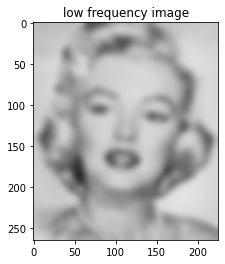

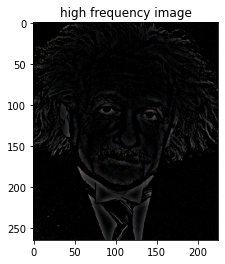

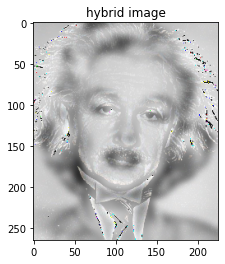

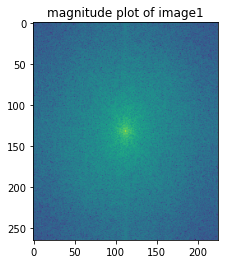

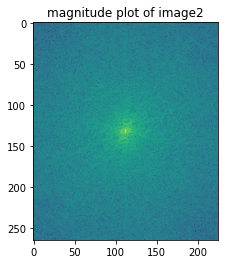

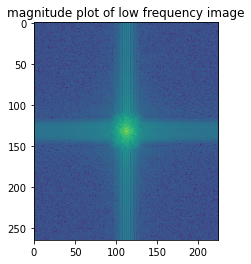

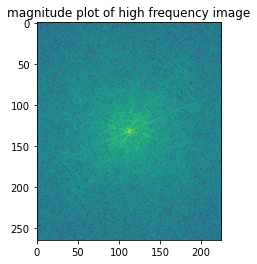

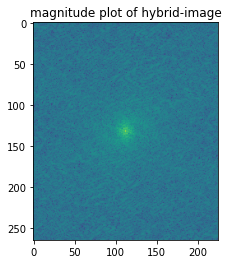

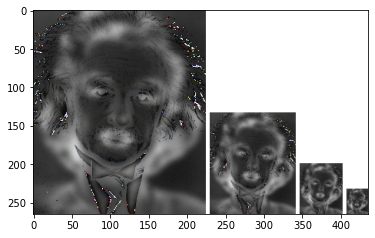

In [152]:
org_im1,org_im2,filt_im1,filt_im2,hy,output,FFT_image_1,FFT_image_2,FFT_image_3,FFT_image_4,FFT_image_hybrid=compute_hybridimage('data/marilyn.bmp','data/einstein.bmp',4)

## **Write-up**


1.   Provide the original and filtered images.
2.   Provide the the hybrid image and hybrid_image_scale using given helper function *vis_hybrid_image*.
3.   Log magnitude of the Fourier transform of the two original images, the filtered images, and the hybrid image.
4.   Briefly explain how this works, using your favorite results as illustrations.

****1.ans:-****


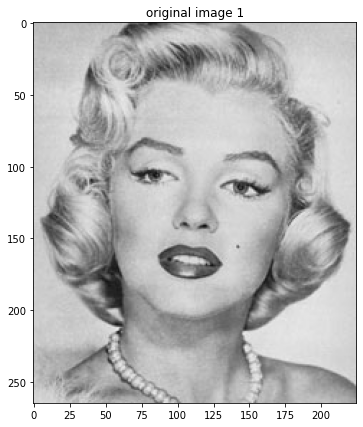

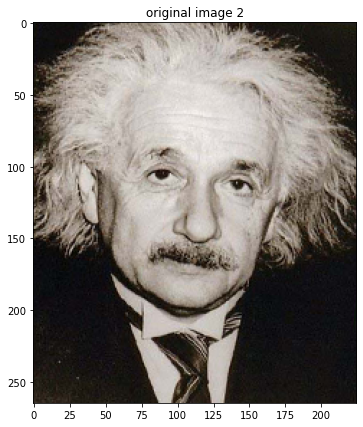

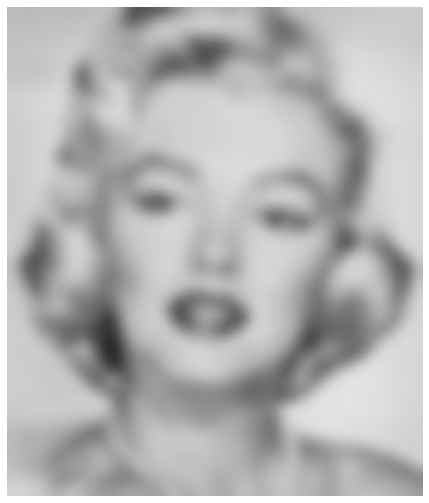

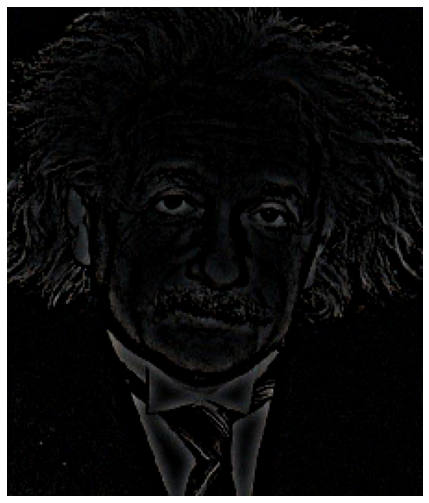

In [42]:
plt.figure(figsize=(7,7))
plt.imshow(org_im1[:,:,::-1])
plt.title("original image 1")
plt.show()

plt.figure(figsize=(7,7))
plt.imshow(org_im2[:,:,::-1])
plt.title("original image 2")
plt.show()

plt.figure(figsize=(9,9))
plt.imshow(filt_im1)
plt.axis("off")
plt.show()

plt.figure(figsize=(9,9))
plt.imshow(filt_im2)
plt.axis("off")
plt.show()

# 2.ans:-

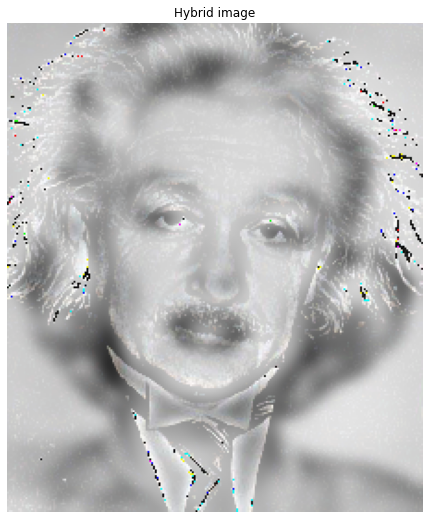

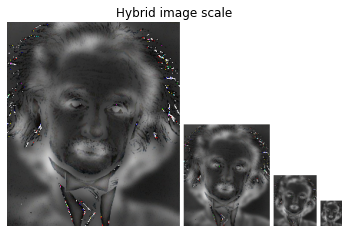

In [43]:
plt.figure(figsize=(9,9))
plt.imshow(hy[:,:,::-1])
plt.title("Hybrid image")
plt.axis("off")
plt.show()
plt.imshow(output)
plt.title("Hybrid image scale")
plt.axis("off")
plt.show()

# 3.Ans:-

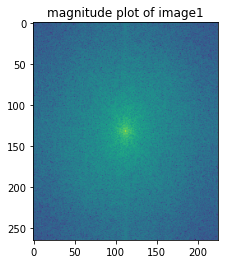

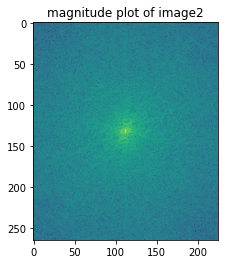

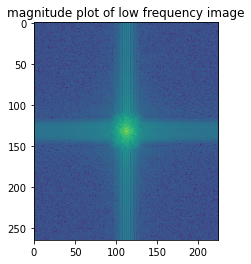

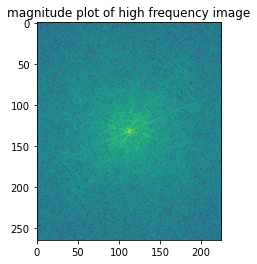

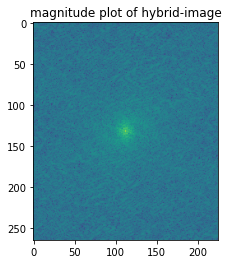

In [44]:
plt.imshow(FFT_image_1)
plt.title("magnitude plot of image1")
plt.show()

plt.imshow(FFT_image_2)
plt.title("magnitude plot of image2")
plt.show()

plt.imshow(FFT_image_3)
plt.title("magnitude plot of low frequency image")
plt.show()

plt.imshow(FFT_image_4)
plt.title("magnitude plot of high frequency image")
plt.show()
  
plt.imshow(FFT_image_hybrid)
plt.title("magnitude plot of hybrid-image")
plt.show()

# 4.Ans:-

A hybrid image is obtained by summing up a low frequency image and a high frequency image.



1.   low frequency image can be obtained by gaussian blur
2.   high frequency image can be obtained by subtracting low frequency image from original image.

These images can also be obtained by filtering images in frequency domain. 

The above images illustrate the obtained results.

# Part B: Pyramid Image (25 Points)

**Include your write-up here**

## Overview
Choose an image that has interesting variety of textures (from Flickr or your own images). The images should be atleast 640X480 pixels and converted to grayscale. Write code for a Gaussian and Laplacian pyramid of level N (use for loops). In each level, the resolution should be reduced by a factor of 2. Show the pyramids for your chosen image in your write-up. Here is an [example](https://drive.google.com/uc?id=17Y287EA-GJ2z0wtm_M7StIWsXyFeHvrz).

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [647]:
# Download Data -- run this cell only one time per runtime
!gdown 1KTDxPAkQam29YKtoX5dKPnLKpUOWCanC
!unzip "/content/hybrid_pyramid_input.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=1KTDxPAkQam29YKtoX5dKPnLKpUOWCanC
To: C:\Users\micro\Downloads\New python 22.9.22\hybrid_pyramid_input.zip

  0%|          | 0.00/2.19M [00:00<?, ?B/s]
 24%|##3       | 524k/2.19M [00:01<00:03, 487kB/s]
 48%|####7     | 1.05M/2.19M [00:01<00:02, 536kB/s]
 72%|#######1  | 1.57M/2.19M [00:02<00:01, 579kB/s]
 96%|#########5| 2.10M/2.19M [00:03<00:00, 650kB/s]
100%|##########| 2.19M/2.19M [00:03<00:00, 617kB/s]
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [47]:
import cv2
import copy
import numpy as np

## Code

In [54]:
# Populate Helper Functions:
%matplotlib inline
# Populate Helper Functions:

def processLaplacianimage(laplacian_image):
    laplacian_image=laplacian_image/255
    laplacian_image=(laplacian_image+1)*0.5

    laplacian_image=np.uint8(laplacian_image*255)
  
    return laplacian_image


def pyramidsGL(image, num_levels):
    ''' Creates Gaussian (G) and Laplacian (L) pyramids of level "num_levels" from image im. 
    G and L are list where G[i], L[i] stores the i-th level of Gaussian and Laplacian pyramid, respectively. '''
  
    filter1 = gaussian_2D_filter(5,2.5)
    G=[]
    G.clear()
    G.append(image)

    for level in range(num_levels-1):
        #smooth the image
        img_blur1=imgfilter(image,filter1)
    
        #downsample the image to half
        down_sampled_image=cv2.resize(img_blur1,None,fx=0.5,fy=0.5,interpolation=cv2.INTER_NEAREST)
        G.append(down_sampled_image)

        image = down_sampled_image

    G1=copy.deepcopy(G)
    L=[]
    L.clear()
    L.append(G1[-1])

    for i in range(len(G) -1):
        upsampled_image = cv2.resize(G[len(G)-i-1],None,fx=2,fy=2,interpolation=cv2.INTER_NEAREST)
        to_subtract = imgfilter(upsampled_image, filter1)
        laplacian = np.double(G[len(G)-i-2]) - np.double(to_subtract)
        laplacian_output=processLaplacianimage(laplacian)
        L.append(laplacian_output)
  
    L.reverse()

    return G, L

def displayPyramids(G, L):
    '''Role of this function is to display intensity and Fast Fourier Transform (FFT) images of pyramids.
    NOTE: You may re-use your helper function  "log_mag_FFT" to compute this.'''

    plt.figure(figsize=(12,7))
    for i,gaus_image in enumerate(G):
        plt.subplot(2,5,i+1)
        plt.axis("off")
        plt.imshow(gaus_image,cmap="gray")
  
    for i,lap_image in enumerate(L):
        plt.subplot(2,5,5+(i+1))
        plt.axis("off")
        plt.imshow(lap_image,cmap="gray")
        

def displayFFT(G, L):
    '''Role of this function is to display intensity and Fast Fourier Transform (FFT) images of pyramids.
    NOTE: You may re-use your helper function  "log_mag_FFT" to compute this.'''

    plt.figure(figsize=(12,7))
    for i,gaus_image in enumerate(G):
        FFT_image_output=log_mag_FFT1(gaus_image)
        plt.subplot(2,5,i+1)
        plt.axis("off")
        plt.imshow(FFT_image_output)
  
    for i,lap_image in enumerate(L):
        FFT_image_output1=log_mag_FFT1(lap_image)
        plt.subplot(2,5,5+(i+1))
        plt.axis("off")
        plt.imshow(FFT_image_output1)

def reconstructLaplacianPyramid(L):
    '''Given a Laplacian Pyramid L, reconstruct an image img.'''
  
    filter1 = gaussian_2D_filter(5,2.5)

    present_gaussian = L[-1]
  
    plt.figure(figsize=(15,15))
    for i in range(len(L)-1):
        upsampled_image = cv2.resize(present_gaussian,None,fx=2,fy=2,interpolation=cv2.INTER_NEAREST)
        to_add = imgfilter(upsampled_image, filter1)
        present_gaussian = (np.double(L[-i-2]) + np.double(upsampled_image))*0.5
        present_gausian=np.uint8(present_gaussian*255)
  
    plt.figure()
    plt.imshow(present_gaussian,cmap='gray')
    plt.title("reconstructed image")
    plt.savefig("reconstructed_image.png")
    plt.show()
    return present_gaussian

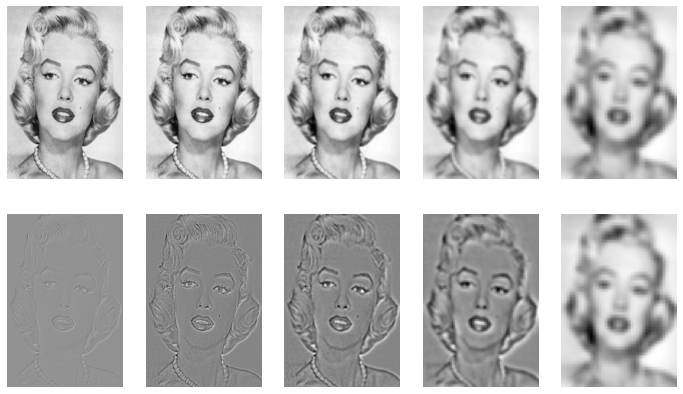

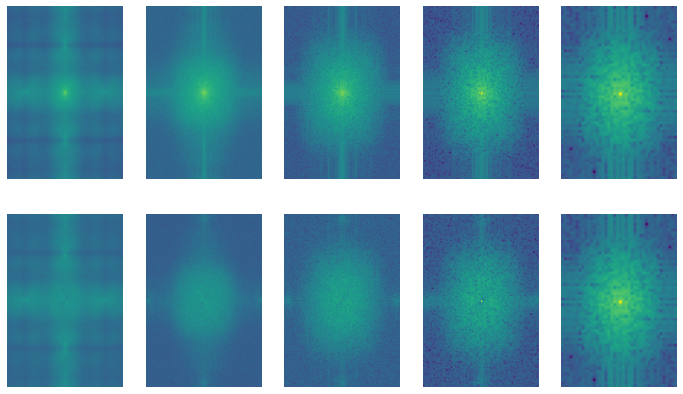

<Figure size 1080x1080 with 0 Axes>

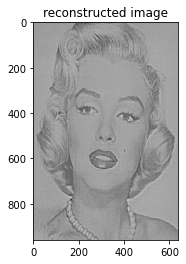

reconstruction error is : 46944.05593696075


In [55]:
""" 
Steps:
1. Load an image im.
2. Call function pyramidsGL with image and num_levels = 5
3. Call function displayPyramids with G, L
4. Call function reconstructLaplacianPyramid with the generated L
5. Compute reconstruction error with L2 norm and print the error value.
"""

# YOUR CODE HERE
image=cv2.imread('./data/marilyn.bmp',cv2.IMREAD_GRAYSCALE)
image=cv2.resize(image,(640,960),interpolation=cv2.INTER_NEAREST)
G_,L_=pyramidsGL(image, 5)
displayPyramids(G_, L_)
displayFFT(G_,L_)
image1=reconstructLaplacianPyramid(L_)

error=np.sqrt(np.sum(np.square(image-image1)))

print(f"reconstruction error is : {error}")

## **Write-up**

1. (10 Points) Display a Gaussian and Laplacian pyramid of level 5 (using your code). It should be formatted similar to [this](https://drive.google.com/file/d/1mAommQeJsp7WS8QCrZRcr8cQiltPPOh2/view?usp=sharing) figure.

2. (10 Points) Display the FFT amplitudes of your Gaussian/Laplacian pyramids Appropriate display ranges (from 0 to 1) should be chosen so that the changes in frequency in different levels of the pyramid are clearly visible. Explain  what the Laplacian and Gaussian pyramids are doing in terms of frequency. [This](https://drive.google.com/file/d/1BqTPKq6Mqqxl5jNNPkvx4JOA5MRgVq08/view?usp=sharing) looks like the expected output.

3. (5 Points) Image Reconstruction


**Include your write-up here**

# 1.ans:-

**Level 5 Gaussian and Laplacian pyramid**

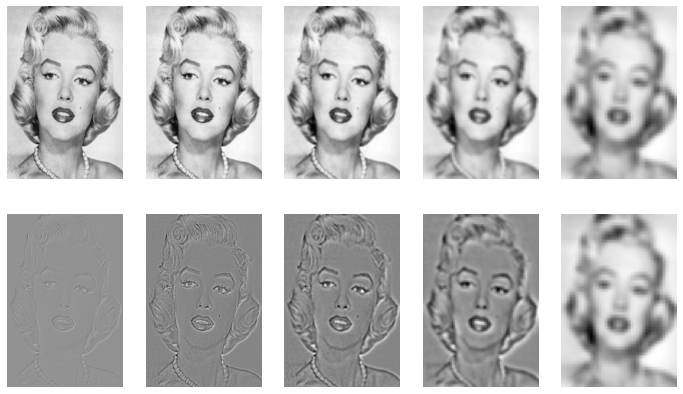

In [57]:
displayPyramids(G_, L_)


# 2.Ans:-

**FFT amplitudes of your Gaussian/Laplacian pyramids**

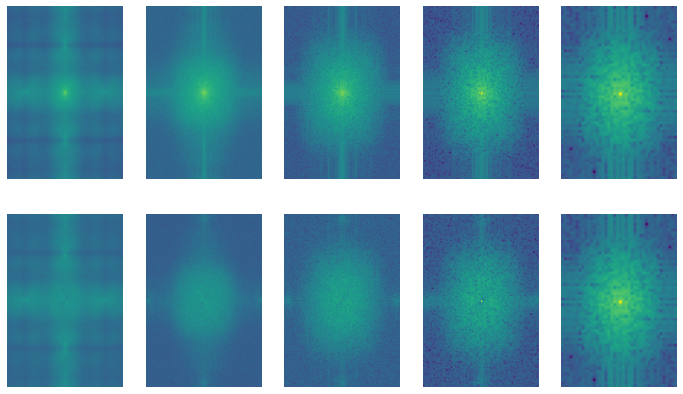

In [59]:
displayFFT(G_,L_)

**In gaussian pyramid as you go down the levels there is significant amount of low and high frequency. Whereas in Laplacian pyramid there is only high frequency component in majority of images.**

# 3.Ans:-

**Image Reconstruction**

<Figure size 1080x1080 with 0 Axes>

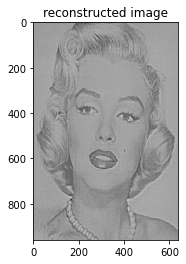

In [66]:
im=reconstructLaplacianPyramid(L_)

# Part C: Edge detection (25 points)

## Overview
The main steps of edge detection are: (1) assign a score to each pixel; (2) find local maxima along the direction perpendicular to the edge. Sometimes a third step is performed where local evidence is propagated so that long contours are more confident or strong edges boost the confidence of nearby weak edges. Optionally, a thresholding step can then convert from soft boundaries to hard binary boundaries. Here are sample outputs.

<table><tr>
<td> <img src="https://drive.google.com/uc?id=1orUji5-1CzjWmHk0g5y5kOVFhshNfhN8" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="https://drive.google.com/uc?id=1npyMjhlRAeP1GaukV38SOlCe-O0whX37" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>
<table><tr>
<td> <img src="https://drive.google.com/uc?id=1TX54zNTG6q5ajitwV024FS-nOJiVP2VN" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="https://drive.google.com/uc?id=1dPPSFDmakh8DQwlpTYmNXJPNHapdZF8S" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

**Hint:** Reading these papers will help understanding and may help with the programming assignment.

[The design and use of steerable filters](http://people.csail.mit.edu/billf/papers/steerpaper91FreemanAdelson.pdf)

[Berkeley Pb Detector](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/papers/mfm-pami-boundary.pdf)

[Multi-scale edge detection](https://home.ttic.edu/~xren/publication/xren_eccv08_multipb.pdf)

## Data
We have provided 50 test images and the codes associated to download the unzip the data. Your job is to build a simple gradient-based edge detector and to extend it using multiple oriented filters.

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [123]:
# Download Data -- run this cell only one time per runtime
!gdown 1zgblBWTQ847yZKnRmM1QrRiEWu1WvEo7
!unzip "/content/edge_detection_inputs.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=1zgblBWTQ847yZKnRmM1QrRiEWu1WvEo7
To: C:\Users\micro\Downloads\New python 22.9.22\edge_detection_inputs.zip

  0%|          | 0.00/3.82M [00:00<?, ?B/s]
 14%|#3        | 524k/3.82M [00:01<00:11, 291kB/s]
 27%|##7       | 1.05M/3.82M [00:02<00:07, 368kB/s]
 41%|####1     | 1.57M/3.82M [00:04<00:05, 409kB/s]
 55%|#####4    | 2.10M/3.82M [00:05<00:03, 436kB/s]
 69%|######8   | 2.62M/3.82M [00:06<00:02, 458kB/s]
 82%|########2 | 3.15M/3.82M [00:07<00:01, 466kB/s]
 96%|#########5| 3.67M/3.82M [00:08<00:00, 509kB/s]
100%|##########| 3.82M/3.82M [00:08<00:00, 529kB/s]
100%|##########| 3.82M/3.82M [00:08<00:00, 459kB/s]
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [117]:
# Import necessary packages
import numpy as np
import cv2


from scipy.interpolate import interp2d

import matplotlib.pyplot as plt

img_path = "C:/Users/micro/Downloads/New python 22.9.22/edge_detection_inputs/101085.jpg" ## add the path here
img_for_edge_detection1= cv2.imread(img_path,cv2.IMREAD_COLOR)

## Subpart 1: Simple edge detection (8 points)
Build a simple gradient-based edge detector that includes the following functions
```
def gradientMagnitude(im, signma)
```
This function should take an RGB image as input, smooth the image with Gaussian std=sigma, compute the x and y gradient values of the smoothed image, and output image maps of the gradient magnitude and orientation at each pixel. You can compute the gradient magnitude of an RGB image by taking the L2-norm of the R, G, and B gradients. The orientation can be computed from the channel corresponding to the largest gradient magnitude. The overall gradient magnitude is the L2-norm of the x and y gradients. mag and theta should be the same size as im.

```
def edgeGradient(im):
```
This function should use gradientMagnitude to compute a soft boundary map and then perform non-maxima suppression. For this assignment, it is acceptable to perform non-maxima suppression by retaining only the magnitudes along the binary edges produce by the Canny edge detector: `cv2.Canny(im)`. 

If desired, the boundary scores can be rescaled, e.g., by raising to an exponent: `mag2 = mag.^0.7` , which is primarily useful for visualization. 


In [118]:
from numpy.core.memmap import dtype
from numpy.core.numerictypes import maximum_sctype

def calculateOrientaion(x_gradient,y_gradient):
    theta=np.arctan2(y_gradient,x_gradient)
    return theta
def gradientMagnitude(im, sigma):
    '''
    im: input image
    sigma: standard deviation value to smooth the image

    outputs: gradient magnitude and gradient direction of the image
    '''
    B,G,R=np.split(im,3,axis=2)

    B_xderivative=cv2.Sobel(B,cv2.CV_32F,1,0)
    B_yderivative=cv2.Sobel(B,cv2.CV_32F,0,1)

    G_xderivative=cv2.Sobel(G,cv2.CV_32F,1,0)
    G_yderivative=cv2.Sobel(G,cv2.CV_32F,0,1)
  
    R_xderivative=cv2.Sobel(R,cv2.CV_32F,1,0)
    R_yderivative=cv2.Sobel(R,cv2.CV_32F,0,1)
  
    # calculating individual channels magnitude gradient

    B_gradient=np.sqrt(np.square(B_xderivative)+np.square(B_yderivative))

    G_gradient=np.sqrt(np.square(G_xderivative)+np.square(G_yderivative))

    R_gradient=np.sqrt(np.square(R_xderivative)+np.square(R_yderivative))
  
    # gradient of RGB channels
    mag=np.sqrt(np.square(B_gradient)+np.square(G_gradient)+np.square(R_gradient))
 

    # normalizing gradient for visulization
    mag_=cv2.normalize(mag,dst=mag,alpha=0,beta=255,norm_type=cv2.NORM_MINMAX,dtype=cv2.CV_8U)
  
    #calculating max magnitude channels, orientation
    list_of_magnitudes=[np.sum(B_gradient),np.sum(G_gradient),np.sum(R_gradient)]
    max_index=list_of_magnitudes.index(max(list_of_magnitudes))

    if(max_index==0):
        theta_array=calculateOrientaion(B_xderivative,B_yderivative)
    elif(max_index==1):
        theta_array=calculateOrientaion(G_xderivative,G_yderivative)
    else:
        theta_array=calculateOrientaion(R_xderivative,R_yderivative)

  # print(theta_array)
  
    #plotting magnitude of gradients
    plt.figure(figsize=[15,15])
    plt.subplot(211)
    plt.imshow(mag_,cmap='gray')
    plt.title("x and y Gradient magnitude")

  # plt.subplot(212)
  # plt.imshow(theta_array)
  # plt.title("Gradient Orientation")
  # plt.show()
  
    return mag_

def edgeGradient(im):
    '''
    im: input image

    output: a soft boundary map of the image
    '''
    mag_=gradientMagnitude(im, 3)
    # gray_image=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    edges_image=cv2.Canny(mag_,180,220)
    plt.imshow(edges_image,cmap='gray')
    plt.title('soft boundary map')
    plt.show()


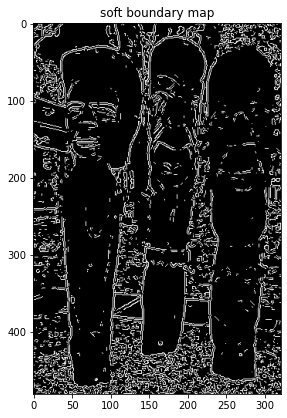

In [119]:
edgeGradient(img_for_edge_detection1)

In [133]:
img_path = "C:/Users/micro/Downloads/New python 22.9.22/edge_detection_inputs/101085.jpg" ## add the path here
img_for_edge_detection2= cv2.imread(img_path,cv2.IMREAD_COLOR)

## Subpart 2: Improved Edge Detection (8 points)
Try to improve your results using a set of oriented filters, rather than the simple derivative of Gaussian approach above, including the following functions:
```
def orientedFilterMagnitude(im):
```
Computes the boundary magnitude and orientation using a set of oriented filters, such as elongated Gaussian derivative filters. Explain your choice of filters in the write-up. Use at least four orientations. One way to combine filter responses is to compute a boundary score for each filter (simply by filtering with it) and then use the max and argmax over filter responses to compute the magnitude and orientation for each pixel.
```
def edgeOrientedFilters(im):
```
Similar to Subpart 1, this should call orientedFilterMagnitude, perform the non-maxima suppression, and output the final soft edge map.

In [134]:
def derivative_of_gaussian_filter(theta):
  
  # building x-derivate of gaussian kernel
  gaussian_kernel=gaussian_2D_filter(5,1)

  derivative_kernel=np.array([-1,0,1])

  gaussian_x_derivative=cv2.filter2D(gaussian_kernel,-1,derivative_kernel)

  # interpolating function
  x_axis=np.arange(-2,3)
  y_axis=np.arange(-2,3)

  # xx,yy=np.meshgrid(x_axis,y_axis)
  # standard_deviation=1
  # z = ((1/(2*np.pi*standard_deviation**2))*np.exp(-0.5*(np.square(xx)+np.square(yy))/np.square(standard_deviation)))

  f=interp2d(x_axis,y_axis,gaussian_x_derivative,kind="linear")


  # rotated points
  x_axis=np.arange(-1,2)
  y_axis=np.arange(-1,2)

  x_points,y_points=np.meshgrid(x_axis,y_axis)
  original_pts=np.array([x_points.flatten(),y_points.flatten()])

  c=np.cos(theta)
  s=np.sin(theta)
  
  rot_matrix=np.array([[c,-s],[s,c]])
  rotated_points=np.dot(rot_matrix,original_pts)

  rotated_x_points=rotated_points[0]
  rotated_y_points=rotated_points[1]

  new_points_coordinates=zip(rotated_x_points,rotated_y_points)

  list1=[]

  for point in new_points_coordinates:
    
    x_cord=point[0]
    y_cord=point[1]
    
    list1.append(np.double(f(x_cord,y_cord)))

  rotated_kernel=np.array([list1[6:9],list1[3:6],list1[0:3]])

  return rotated_kernel

In [135]:
def orientedFilterMagnitude(im):
  '''
  im: input image

  outputs: gradient magnitude and gradient direction of the image
  '''
 
  gaussian__derivative_45_filter=derivative_of_gaussian_filter(45)

  image_gradient_45=cv2.filter2D(im,-1,gaussian__derivative_45_filter)

  image_gradient_45=cv2.normalize(image_gradient_45,dst=image_gradient_45,alpha=0,beta=255,norm_type=cv2.NORM_MINMAX,dtype=cv2.CV_8U)

  # plt.figure(figsize=(9,9))

  # plt.imshow(image_gradient_45,cmap="gray")

  # plt.title("45 degrees gradient")

  # plt.show()
 
  gaussian__derivative_135_filter=derivative_of_gaussian_filter(135)

  image_gradient_135=cv2.filter2D(im,-1,gaussian__derivative_135_filter)

  image_gradient_135=cv2.normalize(image_gradient_135,dst=image_gradient_135,alpha=0,beta=255,norm_type=cv2.NORM_MINMAX,dtype=cv2.CV_8U)


  # plt.imshow(image_gradient_135,cmap="gray")

  # plt.title("135 degrees gradient")

  # plt.show()
    
  return (image_gradient_45,image_gradient_135)

def edgeOrientedFilters(im):
  '''
  im: input image

  output: a soft boundary map of the image
  '''
  image_45,image_135=orientedFilterMagnitude(im)

  edges_image45=cv2.Canny(image_45,200,220)

  edges_image135=cv2.Canny(image_135,180,220)
 
  plt.imshow(edges_image45,cmap='gray')
  plt.title('soft boundary map of 45 degree gradient')
  plt.show()

  plt.imshow(edges_image135,cmap='gray')
  plt.title('soft boundary map of 135 degree gradient')
  plt.show()

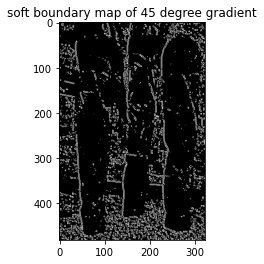

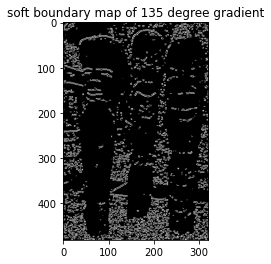

In [136]:
edgeOrientedFilters(img_for_edge_detection2)

## Write-up (9 points)

1.   **(2 points)** Description of any design choices and parameters
2.   **(1 points)** The bank of filters used for Subpart 2 ([plt.imshow with extent](https://stackoverflow.com/questions/13384653/imshow-extent-and-aspect/13390798#13390798) or [cv2.normalize to convert output into grayscale](https://stackoverflow.com/questions/39808545/implement-mat2gray-in-opencv-with-python) may help with visualization)
3.   **(5 points)** Qualitative results: choose five example images; show input images and outputs of each edge detector
4.   **(1 points)** Discuss the quality of your outputs and state one possible way for improvement. Improvements could provide, for example, a better boundary pixel score or a better suppression technique. Your idea could come from a paper you read, but cite any sources of ideas.



**Include your write-up here**

# 1.ans:-

# design choices and parameters:
low frequency of canny edge detector  was set to 200 to helps us track continous edges.
gaussian kernel derivates at 45 and 135 degrees was calculated

# 2.ans:-

## The kind of filters used are

1. x_derivative of gaussian filter 
2. y_derivative of gaussian filter 
3. 45 degree derivative of gaussian filter
4. 135 degree derivative of gaussian filter

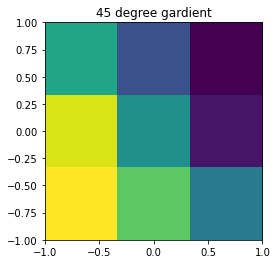

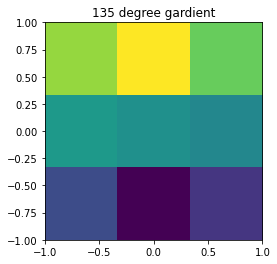

In [101]:
img_45=derivative_of_gaussian_filter(45)
plt.imshow(img_45,extent=[-1,1,-1,+1])
plt.title("45 degree gardient")
plt.show()
img_135=derivative_of_gaussian_filter(135)
plt.imshow(img_135,extent=[-1,1,-1,+1])
plt.title("135 degree gardient")
plt.show()

# 3.ans:-

img_path1 = "C:/Users/micro/Downloads/New python 22.9.22/edge_detection_inputs/103070.jpg" ## add the path here
img_for_edge_detection_1= cv2.imread(img_path1,cv2.IMREAD_COLOR)
edgeGradient(img_for_edge_detection_1)
edgeOrientedFilters(img_for_edge_detection_1)

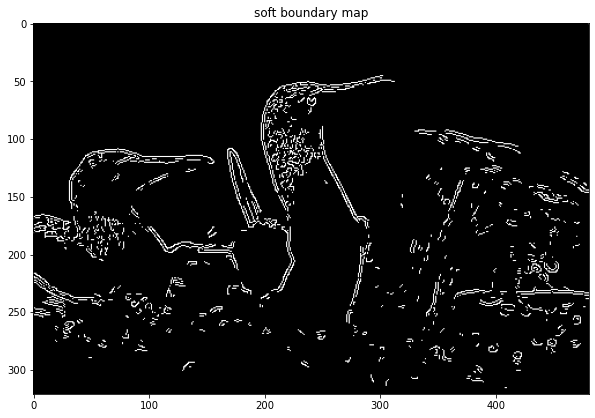

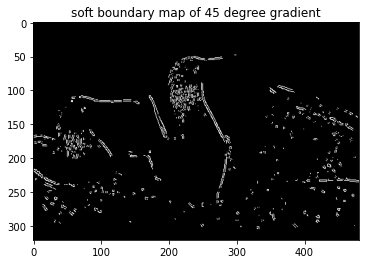

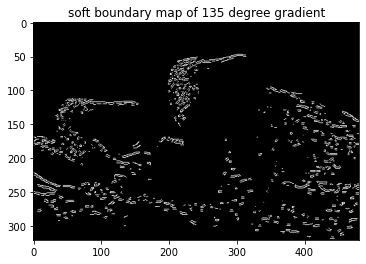

In [141]:
img_path1 = "C:/Users/micro/Downloads/New python 22.9.22/edge_detection_inputs/103070.jpg" ## add the path here
img_for_edge_detection_2= cv2.imread(img_path1,cv2.IMREAD_COLOR)
edgeGradient(img_for_edge_detection_2)
edgeOrientedFilters(img_for_edge_detection_2)

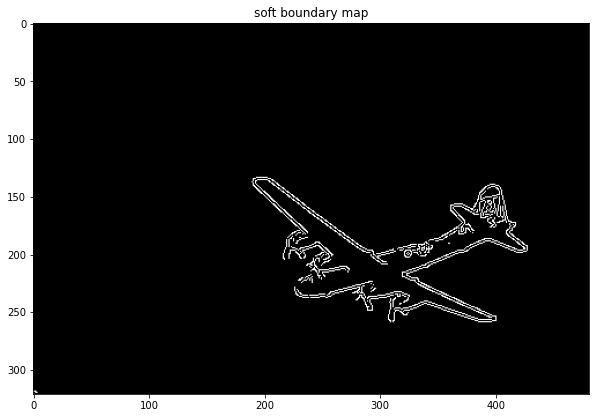

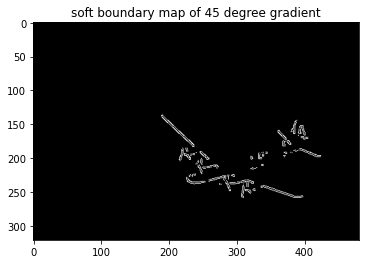

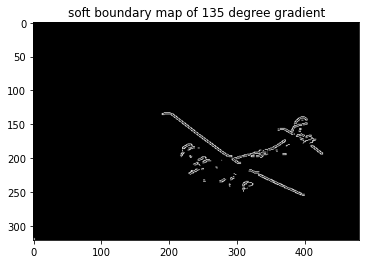

In [148]:
img_path1 = "C:/Users/micro/Downloads/New python 22.9.22/edge_detection_inputs/3096.jpg" ## add the path here
img_for_edge_detection_3= cv2.imread(img_path1,cv2.IMREAD_COLOR)
edgeGradient(img_for_edge_detection_3)
edgeOrientedFilters(img_for_edge_detection_3)

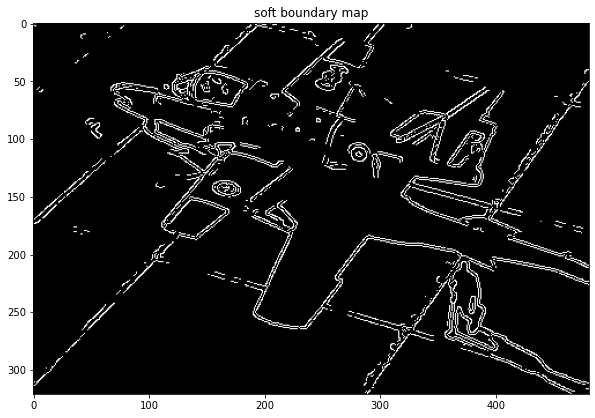

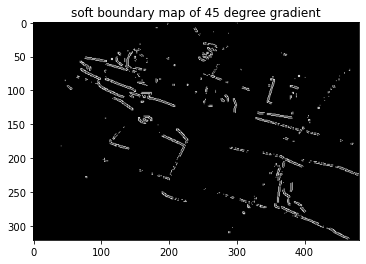

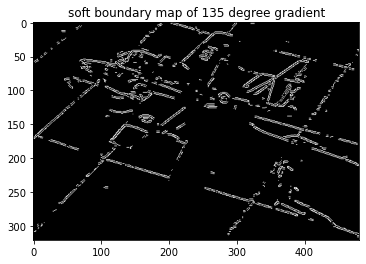

In [149]:
img_path1 = "C:/Users/micro/Downloads/New python 22.9.22/edge_detection_inputs/37073.jpg" ## add the path here
img_for_edge_detection_4= cv2.imread(img_path1,cv2.IMREAD_COLOR)
edgeGradient(img_for_edge_detection_4)
edgeOrientedFilters(img_for_edge_detection_4)

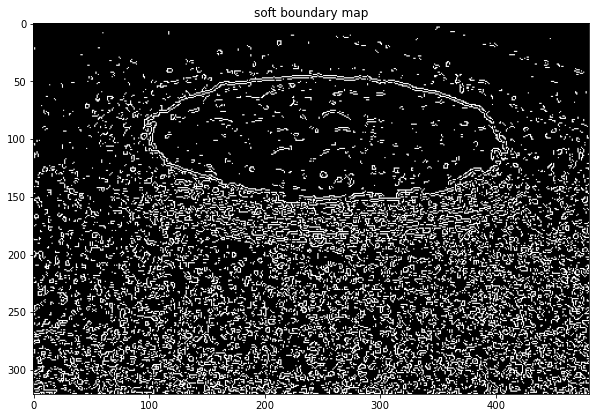

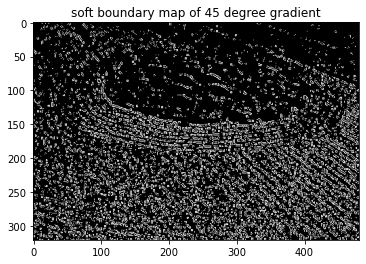

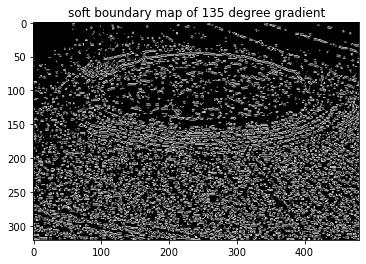

In [140]:
img_path1 = "C:/Users/micro/Downloads/New python 22.9.22/edge_detection_inputs/86016.jpg" ## add the path here
img_for_edge_detection_5= cv2.imread(img_path1,cv2.IMREAD_COLOR)
edgeGradient(img_for_edge_detection_5)
edgeOrientedFilters(img_for_edge_detection_5)

# Part D: Template Matching (25 points) 

## Overview
The goal of this part is to build a template maching algorithm for where's waldo puzzle. 
The end product should be finding waldo in puzzle images. 


## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**


In [122]:
# Download Data -- run this cell only one time per runtime
!gdown 1_PHimFhPSajbTWzAL6-PwM803uzA7Ymb
!unzip "/content/Part4_data.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=1_PHimFhPSajbTWzAL6-PwM803uzA7Ymb
To: C:\Users\micro\Downloads\New python 22.9.22\Part4_data.zip

  0%|          | 0.00/2.04M [00:00<?, ?B/s]
 26%|##5       | 524k/2.04M [00:00<00:02, 554kB/s]
 51%|#####1    | 1.05M/2.04M [00:01<00:01, 723kB/s]
 77%|#######7  | 1.57M/2.04M [00:01<00:00, 943kB/s]
100%|##########| 2.04M/2.04M [00:02<00:00, 1.11MB/s]
100%|##########| 2.04M/2.04M [00:02<00:00, 943kB/s] 
'unzip' is not recognized as an internal or external command,
operable program or batch file.


## Code

We provide the following functions for plotting your results 


In [142]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_image(im,title,xticks=[],yticks= [],cv2 = True):
    """
    im :Image to plot
    title : Title of image 
    xticks : List of tick values. Defaults to nothing
    yticks :List of tick values. Defaults to nothing 
    cv2 :Is the image cv2 image? cv2 images are BGR instead of RGB. Default True
    """
    plt.figure()
    plt.imshow(im[:,:,::-1])
    plt.title(title)
    plt.xticks(xticks)
    plt.yticks(yticks)
    plt.show()

It is always advised for you to visualize and get familar with waldo and puzzle image. 

Visualize both the waldo and puzzle images.

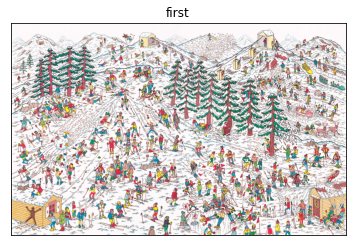

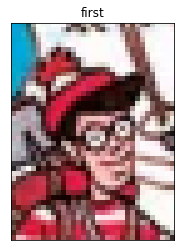

In [143]:
## YOUR CODE HERE
# map=cv2.imread("C:\\Users\\micro\\Downloads\\New python 22.9.22\\Part4_data\\puzzle1\\pic1 (4).jpeg")
# waldo=cv2.imread("C:\\Users\\micro\\Downloads\\pic1 (4).jpeg")
map=cv2.imread("C:\\Users\\micro\\Downloads\\New python 22.9.22\\Part4_data\\puzzle1\\pic1.jpeg")
waldo=cv2.imread("C:\\Users\\micro\\Downloads\\New python 22.9.22\\Part4_data\\puzzle1\\waldo.png")
plot_image(map,"first")
plt.show()
plot_image(waldo,"first")
plt.show()

### Subpart 1: Template Matching with OpenCV
OpenCV provide Template Matching functions below link. 

https://docs.opencv.org/4.x/d4/dc6/tutorial_py_template_matching.html

You can use this function for implementing simple where's waldo algorithm.

This part helps you to understand the concepts of Template Matching and OpenCV Library. This is just for reference.

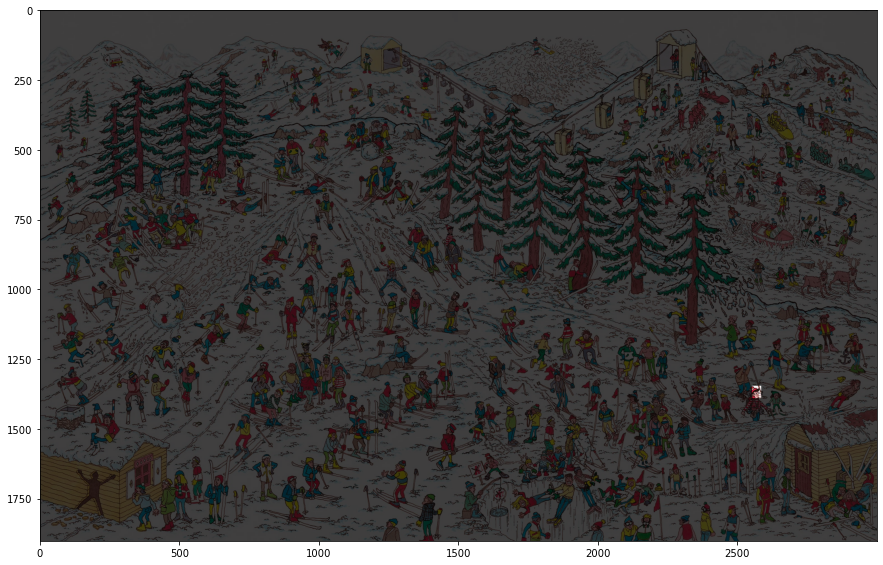

In [144]:
(waldoHeight, waldoWidth) = waldo.shape[:2]

result = cv2.matchTemplate(map, waldo, cv2.TM_CCOEFF)
(_, _, minLoc, maxLoc) = cv2.minMaxLoc(result)

# grab the bounding box of waldo and extract him from the puzzle image
topLeft = maxLoc
botRight = (topLeft[0] + waldoWidth, topLeft[1] + waldoHeight)
roi = map[topLeft[1] : botRight[1], topLeft[0] : botRight[0]]

# construct a darkened transparent 'layer' to darken everything
# in the map except for Waldo
mask = np.zeros(map.shape, dtype = "uint8")
map = cv2.addWeighted(map, 0.25, mask, 0.75, 0)

map[topLeft[1] : botRight[1], topLeft[0] : botRight[0]] = roi

# display the images
result_rgb = cv2.cvtColor(map, cv2.COLOR_RGB2BGR)
plt.figure(figsize = (15, 15))
plt.imshow(result_rgb)

### Subpart 2: Template Matching from Scratch

Implement the Sum of Squared Distance (SSD) template matching algorithm from scratch (Don't use cv2.matchTemplate).

Then, show the results of where's waldo for two puzzle images.

Hints: You can borrow the codes from Part1 and Part2. Please read methods for matching with filters in Lecture Slide.  

In [145]:
## YOUR CODE HERE
def templateMatching(img,template):
    image_copy=img.copy()

    img_gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    template_gray=cv2.cvtColor(template,cv2.COLOR_BGR2GRAY)
  
    im_height,im_width=img.shape[:2]
    template_height,template_width=template.shape[:2]
    SSD_height,SSD_width=(im_height-template_height+1,im_width-template_width+1)
    SSD_magnitude_image=np.zeros((SSD_height,SSD_width))

    for h_i in range(SSD_height):
        for w_i in range(SSD_width):
            image_patch=img[h_i:h_i+template_height,w_i:w_i+template_width]
            SSD_magnitude_image[h_i,w_i]=np.sum(np.square(image_patch-template))
        _,_,min_loc,max_loc=cv2.minMaxLoc(SSD_magnitude_image)
        top_left_w,top_left_h = min_loc

    plt.figure(figsize=(9,9))
    plt.imshow(SSD_magnitude_image,cmap="gray")
    plt.title("sum of square differences magnitude")
    plt.show()

    # extract matched template
    matched_template=img[top_left_h:top_left_h+template_height,top_left_w:top_left_w+template_width]

    plt.imshow(matched_template[:,:,::-1])
    plt.title("template found in original image")
    plt.show()

    #creating transparent image
    mask = np.zeros(img.shape, dtype = "uint8")
    img1 = cv2.addWeighted(img, 0.25, mask, 0.75, 0)

    img1[top_left_h:top_left_h+template_height,top_left_w:top_left_w+template_width]=matched_template
  
    plt.figure(figsize = (15, 15))
    plt.imshow(img1[:,:,::-1])
    plt.title("Template in original image")
    plt.show()

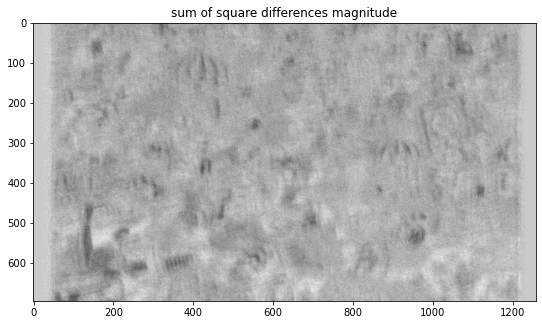

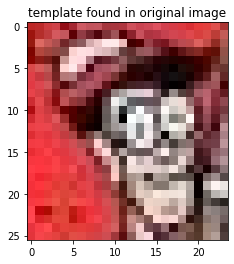

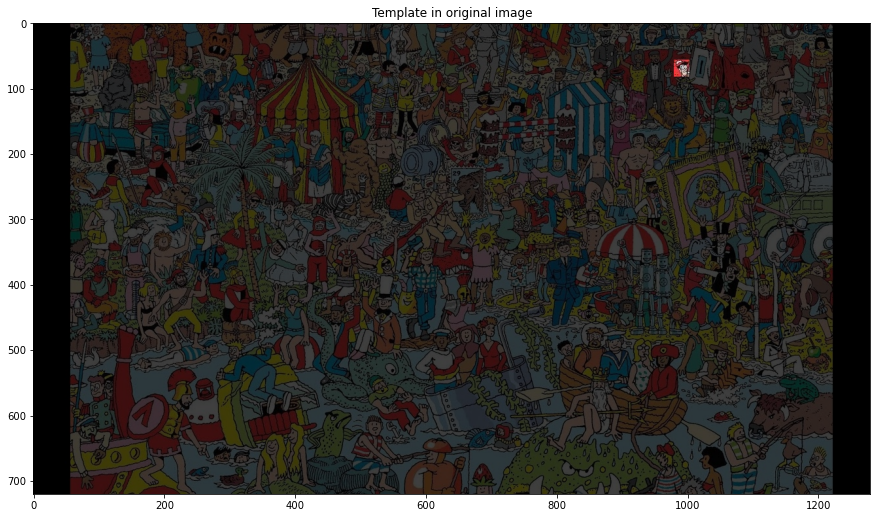

In [147]:
map1=cv2.imread("C:/Users/micro/Downloads/New python 22.9.22/Part4_data/puzzle2/map.jpg",cv2.IMREAD_COLOR)
waldo1=cv2.imread("C:/Users/micro/Downloads/New python 22.9.22/Part4_data/puzzle2/waldo.png",cv2.IMREAD_COLOR)
templateMatching(map1,waldo1)